# Models for House Prices: Advanced Regression Techniques

@roman avj

27 jan 2024

# Settings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

import catboost as cb
from sklearn.linear_model import LinearRegression

# create pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# column transformer
from sklearn.compose import ColumnTransformer
# rmse, mae, mape
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error



# Data

In [3]:
# read data
df_raw = pd.read_csv('../data/train.csv')

# get shapes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# wrangle data
def tidy_df(df):
    # get params
    CURR_YEAR = 2010
    # transform
    df = (
        df
        #### var engineer ####
        .assign(
            CurrentAge=lambda dfx: CURR_YEAR - np.maximum(dfx['YearBuilt'], dfx['YearRemodAdd']),
            PorchArea=lambda dfx: dfx['OpenPorchSF'] + dfx['EnclosedPorch'] +\
                 dfx['3SsnPorch'] + dfx['ScreenPorch'],
            TotalBaths=lambda dfx: dfx['FullBath'] + dfx['HalfBath'],
            Story=lambda dfx: np.select(
                [
                    dfx['HouseStyle'].str.contains('1Story'),
                    dfx['HouseStyle'].str.contains('1.5Fin'),
                    dfx['HouseStyle'].str.contains('1.5Unf'),
                    dfx['HouseStyle'].str.contains('2Story'),
                    dfx['HouseStyle'].str.contains('2.5Fin'),
                    dfx['HouseStyle'].str.contains('2.5Unf'),
                    dfx['HouseStyle'].str.contains('SFoyer'),
                    dfx['HouseStyle'].str.contains('SLvl')
                ],
                [
                    'one',
                    'one_and_half',
                    'one_and_half',
                    'two',
                    'two_and_half',
                    'two_and_half',
                    'split',
                    'split'
                ]
            ),
            StoryFinish=lambda dfx: np.where(
                dfx['HouseStyle'].str.contains('Unf'), 'unfinished', 'finished'
            ),
        )
    )

    return df

def subset_df(df, cols):
    df = (
        df
        #### filters ####
        # no properties with 0 bedrooms or 0 bathrooms
        .query('TotRmsAbvGrd > 0 and TotalBaths > 0')
        # no lot area bigger than 200,000 sqft
        .query('LotArea < 200000')
        # no porch area bigger than 1,000 sqft
        .query('PorchArea < 1000')
        # subset by sale type
        .query('SaleType in ["WD", "New"]')
        # subset by sale condition
        .query('SaleCondition in ["Normal", "Partial"]')
        # subset by mszoning
        .query('MSZoning in ["RL", "RM", "RP", "RH"]')
    )
    # subset
    df = df[cols].reset_index(drop=True)
    return df

# tidy data #
# cols
colsnumeric = [
    'CurrentAge',
    'LotArea', 'PorchArea',
    'TotRmsAbvGrd', 'TotalBaths',
    'OverallQual', 'OverallCond', 'GrLivArea'
]
cat_cols = [
    'SaleType', 'SaleCondition', 
    'MSZoning',
    'Story', 'StoryFinish'
]
cols = colsnumeric + cat_cols + ['Id', 'SalePrice']
# tidy
df = tidy_df(df_raw)
df = subset_df(df, cols)

# get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CurrentAge     1218 non-null   int64 
 1   LotArea        1218 non-null   int64 
 2   PorchArea      1218 non-null   int64 
 3   TotRmsAbvGrd   1218 non-null   int64 
 4   TotalBaths     1218 non-null   int64 
 5   OverallQual    1218 non-null   int64 
 6   OverallCond    1218 non-null   int64 
 7   GrLivArea      1218 non-null   int64 
 8   SaleType       1218 non-null   object
 9   SaleCondition  1218 non-null   object
 10  MSZoning       1218 non-null   object
 11  Story          1218 non-null   object
 12  StoryFinish    1218 non-null   object
 13  Id             1218 non-null   int64 
 14  SalePrice      1218 non-null   int64 
dtypes: int64(10), object(5)
memory usage: 142.9+ KB


In [5]:
# percent of filtered rows
print(f"percent of filtered rows: {round(100*(1 - df.shape[0]/df_raw.shape[0]), 2)}%")

percent of filtered rows: 16.58%


In [6]:
# set index to id
df.set_index('Id', inplace=True)

# split data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1), df['SalePrice'], test_size=0.1, random_state=42, stratify=df['SaleType']
)

# Models

## All vars

### Baseline Model

In [7]:
# pipeline for categorical and numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colsnumeric),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# linear regression
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# fit
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CurrentAge', 'LotArea',
                                                   'PorchArea', 'TotRmsAbvGrd',
                                                   'TotalBaths', 'OverallQual',
                                                   'OverallCond',
                                                   'GrLivArea']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SaleType', 'SaleCondition',
                                                   'MSZoning', 'Story',
                                                   'StoryFinish'])])),
                ('regressor', LinearRegression())])

In [8]:
def regression_metrics(y_true, y_pred, exp=False):
    if exp:
        y_true = (y_true)
        y_pred = (y_pred)
    # rmse
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # mae
    mae = mean_absolute_error(y_true, y_pred)
    # mape
    mape = mean_absolute_percentage_error(y_true, y_pred)

    if exp:
        print("metrics")
    else:
        print("metrics (log)")
    print(f"{'='*50}")
    print(f"rmse: {np.round(rmse, 4)}")
    print(f"mae: {np.round(mae, 4)}")
    print(f"mape: {np.round(mape, 4)}")
    print("\n\n")


# predict
y_pred = lr.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)

metrics (log)
rmse: 33121.044
mae: 22095.1738
mape: 0.1248





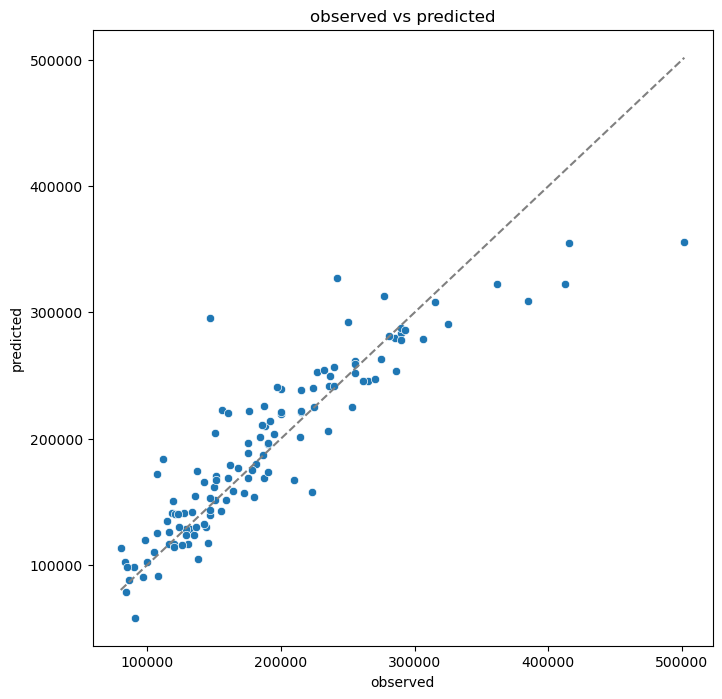

In [9]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=(y_test), y=(y_pred))
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

### CatBoost

In [10]:
# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.01,
    random_seed=42,
    verbose=True
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 79486.3515193	total: 59.6ms	remaining: 59.5s
1:	learn: 78970.5729412	total: 62.4ms	remaining: 31.1s
2:	learn: 78493.8491416	total: 67.4ms	remaining: 22.4s
3:	learn: 78026.4744085	total: 73.6ms	remaining: 18.3s
4:	learn: 77569.2572218	total: 75.4ms	remaining: 15s
5:	learn: 77049.6575669	total: 77.9ms	remaining: 12.9s
6:	learn: 76581.1065197	total: 79.1ms	remaining: 11.2s
7:	learn: 76112.5229507	total: 80.1ms	remaining: 9.94s
8:	learn: 75655.0980486	total: 81.6ms	remaining: 8.98s
9:	learn: 75213.2412468	total: 83.2ms	remaining: 8.23s
10:	learn: 74741.5167422	total: 85.8ms	remaining: 7.71s
11:	learn: 74303.4381829	total: 87.6ms	remaining: 7.21s
12:	learn: 73839.9912114	total: 89.5ms	remaining: 6.8s
13:	learn: 73434.0394117	total: 92.4ms	remaining: 6.51s
14:	learn: 72998.5021728	total: 94ms	remaining: 6.17s
15:	learn: 72542.8127592	total: 97ms	remaining: 5.96s
16:	learn: 72095.9173562	total: 98.6ms	remaining: 5.7s
17:	learn: 71654.7723812	total: 100ms	remaining: 5.47s
18:	learn: 

In [11]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)


metrics (log)
rmse: 25533.3534
mae: 16507.3943
mape: 0.0976





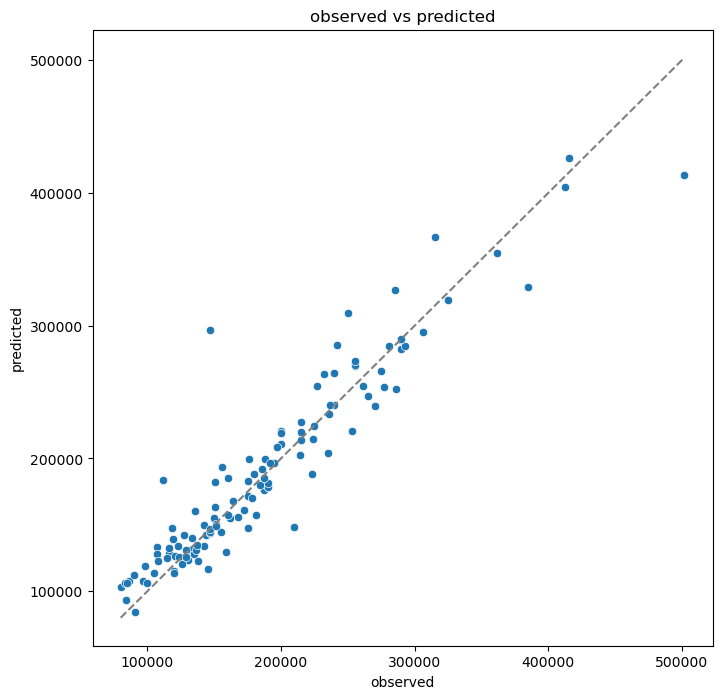

In [12]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=(y_test), y=(y_pred))
plt.xlabel('observed')  
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

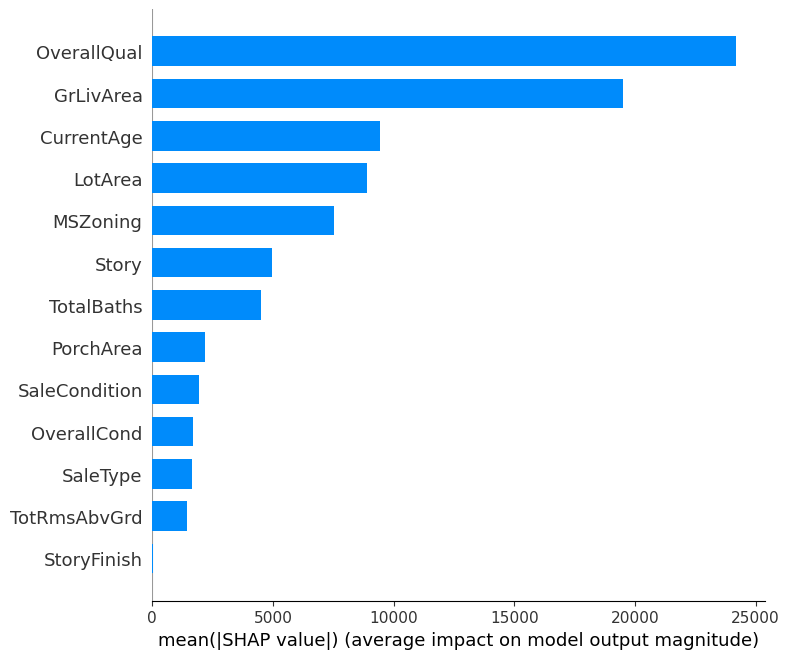

In [13]:
# look shape values
# import Pool
from catboost import Pool
# import shap
import shap
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()


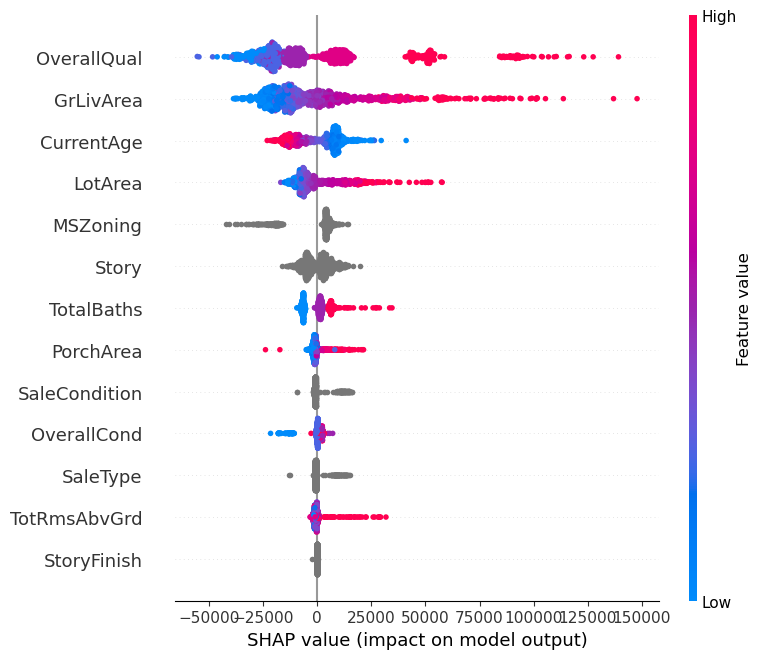

In [14]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

## Subset vars

In [15]:
# cols
colsnumeric = [
    'CurrentAge', 'GrLivArea',
    'LotArea', 'OverallCond',
    'OverallQual'
]
cat_cols = [
    'MSZoning'
]
cols = colsnumeric + cat_cols + ['SalePrice']

# df work
df_work = df[cols].copy()


# split data
X_train, X_test, y_train, y_test = train_test_split(
    df_work.drop(['SalePrice'], axis=1), df_work['SalePrice'], 
    test_size=0.1, random_state=42, stratify=df_work['MSZoning']
)


### Linear regression

In [16]:
# pipeline for categorical and numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colsnumeric),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# linear regression
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# fit
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CurrentAge', 'GrLivArea',
                                                   'LotArea', 'OverallCond',
                                                   'OverallQual']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning'])])),
                ('regressor', LinearRegression())])

In [17]:
# predict
y_pred = lr.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)

metrics (log)
rmse: 32384.6536
mae: 24560.0083
mape: 0.138





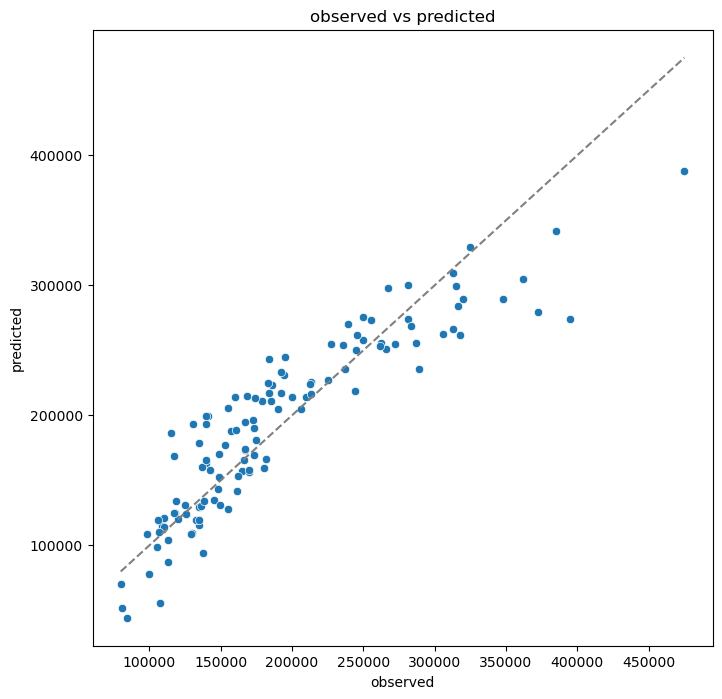

In [18]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=(y_test), y=(y_pred))
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

### CatBoost

In [19]:
# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.01,
    random_seed=42,
    verbose=True
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 79455.8296629	total: 1.76ms	remaining: 1.76s
1:	learn: 78945.1670194	total: 3.02ms	remaining: 1.51s
2:	learn: 78410.9850929	total: 4.42ms	remaining: 1.47s
3:	learn: 77877.9656016	total: 6.17ms	remaining: 1.54s
4:	learn: 77372.8427629	total: 7.49ms	remaining: 1.49s
5:	learn: 76889.3836968	total: 8.66ms	remaining: 1.44s
6:	learn: 76413.9595415	total: 9.73ms	remaining: 1.38s
7:	learn: 75966.5451514	total: 10.5ms	remaining: 1.31s
8:	learn: 75482.6629780	total: 11.8ms	remaining: 1.3s
9:	learn: 75067.3819035	total: 12.3ms	remaining: 1.21s
10:	learn: 74606.2993622	total: 13.2ms	remaining: 1.19s
11:	learn: 74108.6460225	total: 14.7ms	remaining: 1.21s
12:	learn: 73677.6586322	total: 16ms	remaining: 1.22s
13:	learn: 73199.8696510	total: 16.9ms	remaining: 1.19s
14:	learn: 72742.5413562	total: 17.8ms	remaining: 1.17s
15:	learn: 72272.3280646	total: 19.2ms	remaining: 1.18s
16:	learn: 71788.4315990	total: 20.3ms	remaining: 1.18s
17:	learn: 71348.8184154	total: 21.5ms	remaining: 1.17s
18:	l

In [20]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)

metrics (log)
rmse: 26939.5488
mae: 19776.5613
mape: 0.102





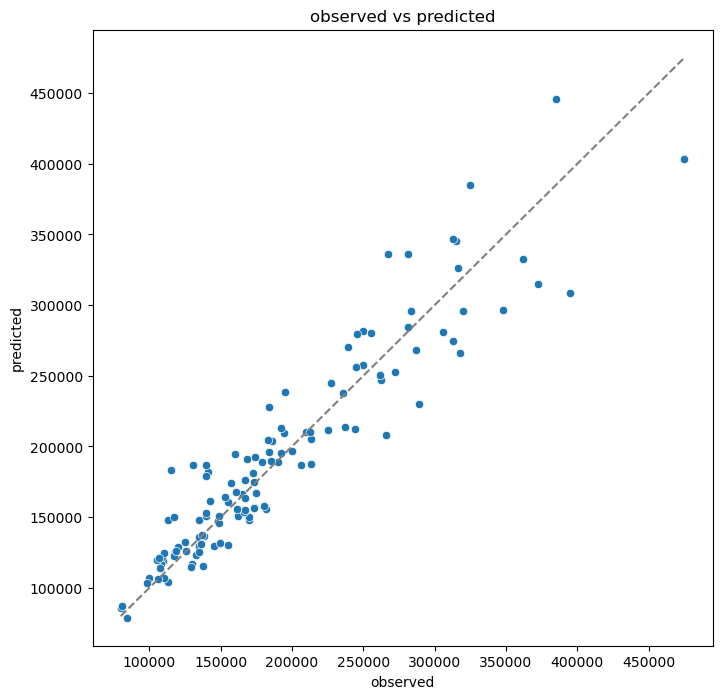

In [21]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=(y_test), y=(y_pred))
plt.xlabel('observed')  
plt.ylabel('predicted')
plt.title('observed vs predicted')
plt.show()

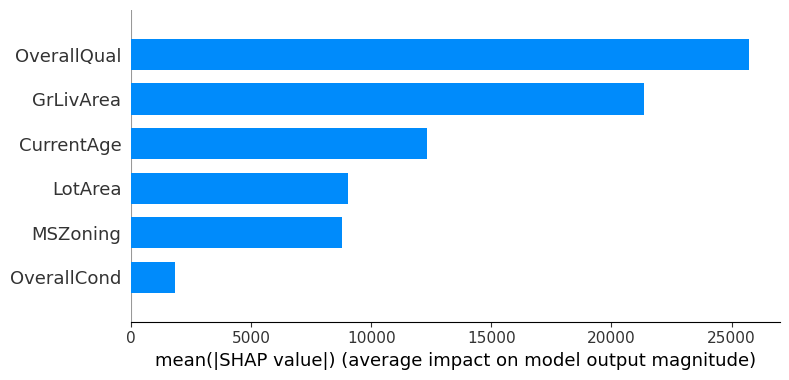

In [22]:
# look shape values
# import Pool
from catboost import Pool
# import shap
import shap
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()


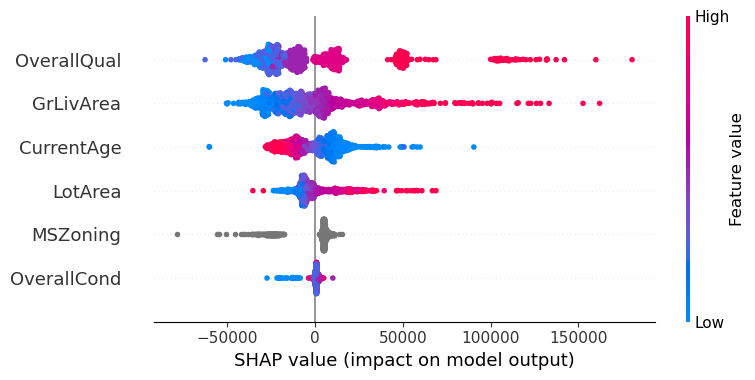

In [23]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

### catboost + monotonicity

In [24]:
# monotonicity constraints
# monotonicity constraints in current age
monotone_constrains = "GrLivArea:1,OverallQual:1,CurrentAge:-1,OverallCond:1,LotArea:1"

# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.5,
    random_seed=42,
    verbose=True,
    monotone_constraints=monotone_constrains
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 59632.8239138	total: 2.8ms	remaining: 2.79s
1:	learn: 48214.5759714	total: 5.34ms	remaining: 2.67s
2:	learn: 42122.1354708	total: 7.46ms	remaining: 2.48s
3:	learn: 38162.1932827	total: 10ms	remaining: 2.49s
4:	learn: 36538.1256839	total: 12.3ms	remaining: 2.45s
5:	learn: 35661.9984778	total: 14.7ms	remaining: 2.44s
6:	learn: 35166.6360189	total: 17.4ms	remaining: 2.46s
7:	learn: 34602.3970795	total: 19.6ms	remaining: 2.43s
8:	learn: 34266.1053434	total: 21.6ms	remaining: 2.38s
9:	learn: 34122.7948672	total: 23.8ms	remaining: 2.36s
10:	learn: 33637.2763384	total: 25.2ms	remaining: 2.27s
11:	learn: 33553.4181776	total: 26.8ms	remaining: 2.21s
12:	learn: 33279.1974261	total: 29.1ms	remaining: 2.21s
13:	learn: 33197.0281284	total: 30.6ms	remaining: 2.15s
14:	learn: 33018.4491270	total: 32ms	remaining: 2.1s
15:	learn: 32860.9196467	total: 33.8ms	remaining: 2.08s
16:	learn: 32594.4967444	total: 35.4ms	remaining: 2.05s
17:	learn: 32482.4323817	total: 37.2ms	remaining: 2.03s
18:	lear

In [25]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)

metrics (log)
rmse: 26946.1278
mae: 19709.3629
mape: 0.1012





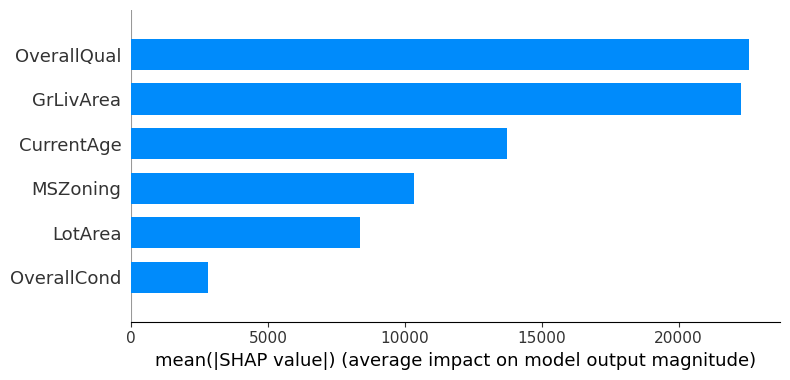

In [26]:
# look shape values
# import Pool
from catboost import Pool
# import shap
import shap
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()


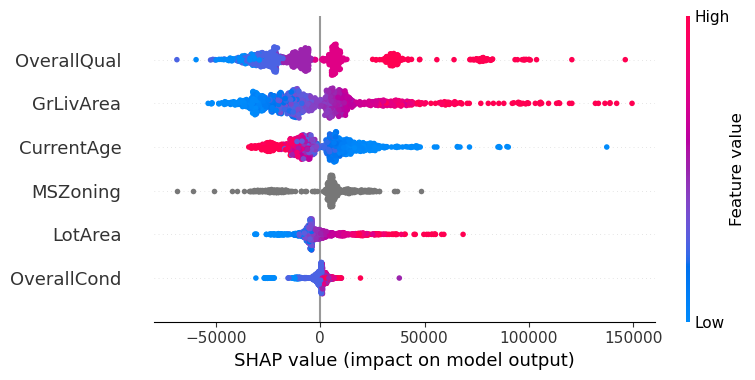

In [27]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

# Best Model

catboost with monotonocity

the rationale is that even though the model is not the best in terms of RMSE, it is the best in terms of interpretability. The model is able to explain the relationship between the features and the target variable.

In [28]:
# monotonicity constraints
monotone_constrains = "GrLivArea:1,OverallQual:1,CurrentAge:-1,OverallCond:1,LotArea:1"

# fit catboost
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    learning_rate=0.5,
    random_seed=42,
    verbose=True,
    monotone_constraints=monotone_constrains
)
# fit
cb_model.fit(X_train, y_train, cat_features=cat_cols, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 59632.8239138	total: 2.74ms	remaining: 2.73s
1:	learn: 48214.5759714	total: 4.86ms	remaining: 2.42s
2:	learn: 42122.1354708	total: 7.07ms	remaining: 2.35s
3:	learn: 38162.1932827	total: 10ms	remaining: 2.5s
4:	learn: 36538.1256839	total: 12.2ms	remaining: 2.42s
5:	learn: 35661.9984778	total: 14.9ms	remaining: 2.46s
6:	learn: 35166.6360189	total: 16.8ms	remaining: 2.38s
7:	learn: 34602.3970795	total: 18.5ms	remaining: 2.3s
8:	learn: 34266.1053434	total: 19.9ms	remaining: 2.19s
9:	learn: 34122.7948672	total: 22.5ms	remaining: 2.22s
10:	learn: 33637.2763384	total: 24.3ms	remaining: 2.18s
11:	learn: 33553.4181776	total: 26.2ms	remaining: 2.15s
12:	learn: 33279.1974261	total: 28.7ms	remaining: 2.18s
13:	learn: 33197.0281284	total: 30.3ms	remaining: 2.13s
14:	learn: 33018.4491270	total: 31.9ms	remaining: 2.09s
15:	learn: 32860.9196467	total: 34.5ms	remaining: 2.12s
16:	learn: 32594.4967444	total: 36.2ms	remaining: 2.09s
17:	learn: 32482.4323817	total: 37.7ms	remaining: 2.06s
18:	le

In [29]:
# predict
y_pred = cb_model.predict(X_test)

# get metrics
regression_metrics(y_test, y_pred)

metrics (log)
rmse: 26946.1278
mae: 19709.3629
mape: 0.1012





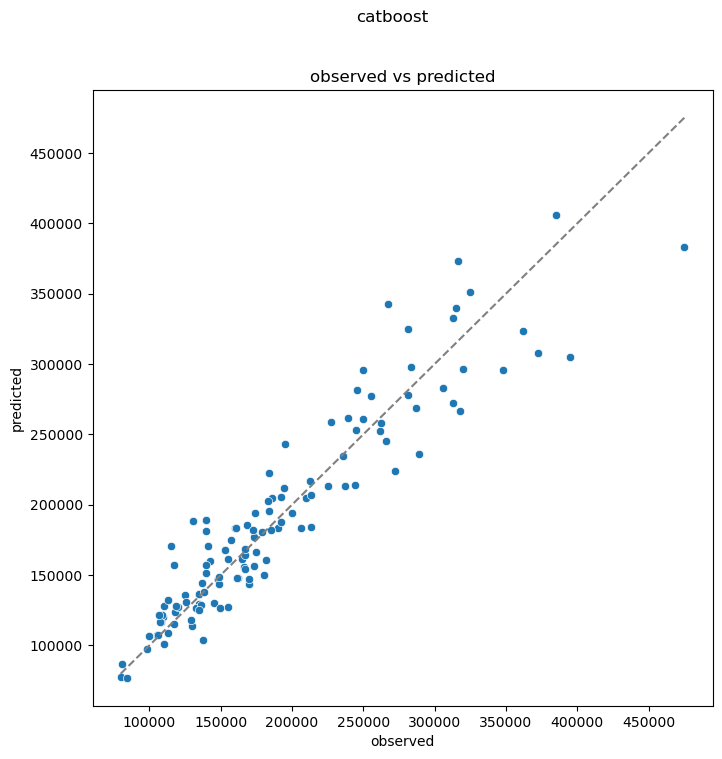

In [30]:
# plot observed vs predicted
plt.figure(figsize=(8, 8))
# add identity line
plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], c='gray', linestyle='--')
# get residuals
sns.scatterplot(x=(y_test), y=(y_pred))
plt.xlabel('observed')  
plt.ylabel('predicted')
plt.title('observed vs predicted')
# subtitle: catboost 
plt.suptitle('catboost')
plt.show()

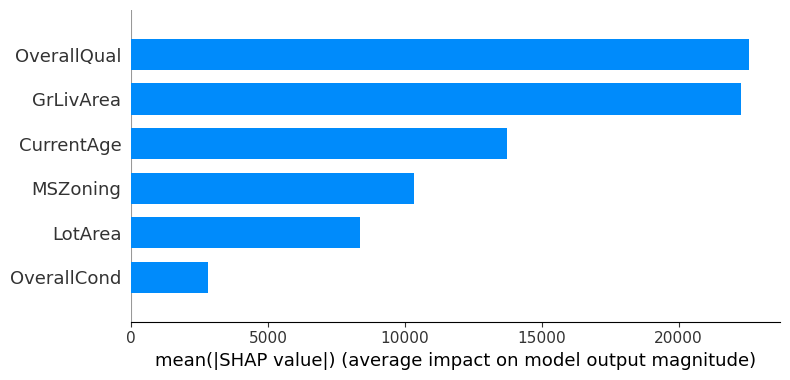

In [31]:
# get shape values
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_cols), type='ShapValues')
# plot
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train, plot_type='bar')
plt.show()

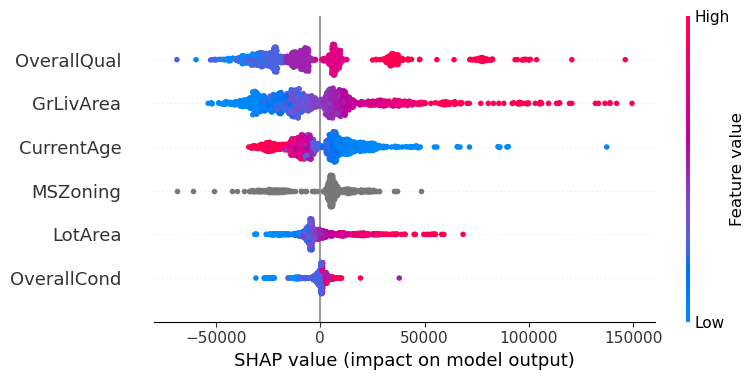

In [32]:
# plot bee swarm
plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values[:, :-1], X_train)
plt.show()

In [33]:
# save model
cb_model.save_model('../models/catboost_model_no_log.cbm')

# Sandbox

In [34]:
X_train.iloc[0]

CurrentAge       11
GrLivArea      2060
LotArea        8755
OverallCond       5
OverallQual       7
MSZoning         RL
Name: 942, dtype: object

In [35]:
y_train.iloc[0]

214000